# Attention
* 随意线索（跟随意图的线索，volitional cue)，比如一堆不显眼的物件中一杯用亮红色被子装的咖啡


* 不随意线索 （不跟随意图的线索，nonvolitional cue)，不如想要在一堆不显眼的物件中找出一本书读


* 卷积， 全连接，池化层都只考虑不随意线索


* 注意力机制则显示的考虑随意线索
    * 随意线索被称之为 查询（query）
    * 每个输入是一个值 （value）和不随意线索（key）的对
    * 通过注意力池化层来有偏向性的选择某些输入

## Non-parametric attention pooling

* 给定数据: $(x_i, y_i)$, $i=1,...,n$
* Average Pooling 是最简单的方案: $f(x) = \frac{1}{n} \sum_i y_i$
* 更好的方案是**60年代提出来的**Nadaraya-Watson Kernel Regression:
$$
f(x) = \sum_{i=1}^{n} \frac{K(x-x_i)}{\sum^n_{j=1} K(x-x_j)}y_i
$$
where $f(x)$ is **query**, $x_j$ is **key**, $y_i$ is **value**, and $K$ is the kernel, or a function to measure the distance between $x$ and $x_i$, 

### Nadaraya-Watson Kernel Regression

* Gaussian Kernel:
$$
K(u) = \frac{1}{\sqrt{2\pi}}\exp\left(-\frac{u^2}{2}\right)
$$
Then:
$$
f(x) = \sum_{i=1}^{n} \frac{\exp\left(-\frac{1}{2}(x-x_i)^2\right)}{\sum^n_{j=1} \exp\left(-\frac{1}{2}(x-x_j)^2\right)}y_i
$$


$$
= \sum_{i=1}^{n} \mathrm{softmax}\left(-\frac{1}{2}(x-x_i)^2\right)y_i
$$

* 在之前基础上引入可学习的$w$ (scaler)
$$
f(x) = \sum_{i=1}^{n} \mathrm{softmax}\left(-\frac{1}{2}[(x-x_i)w]^2\right)y_i
$$

* 可以一般的写作$f(x) = \sum_i \alpha(x,x_i)y_i$， 这里$\alpha(x,x_i)$是注意力权重


* Softmax 里面的被称为注意力分数(attention score)


* 多个不同的权重设计

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2 * torch.sin(x) + x ** .8

y_train = f(x_train) + torch.normal(0.0, .5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)

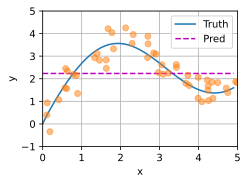

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
            xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=.5)
    
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

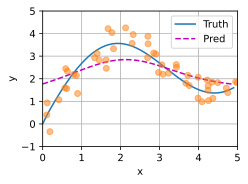

In [4]:
# Non-parametric attention pooling
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
attention_weights = nn.functional.softmax(-(X_repeat - x_train) ** 2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

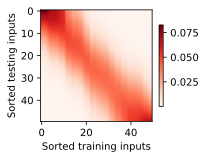

In [5]:
d2l.show_heatmaps(
    attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

带参数注意力汇聚
* 假定两个张量的形状分别是(n,a,b)和(n,b,c),他们的批量矩阵乘法输出形状为(n,a,c)

In [6]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

使用小批量矩阵乘法来计算小批量数据中的加权平均值

In [7]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

## 带参数的注意力汇聚 (Parametric Attention Pooling)

In [25]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape(
            (-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

### 将训练数据集转换为key和value

In [26]:
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))

训练带参注意力汇聚模型

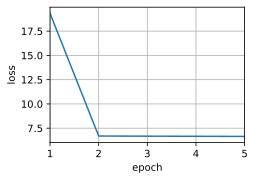

In [27]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
optim = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    optim.zero_grad()
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    optim.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

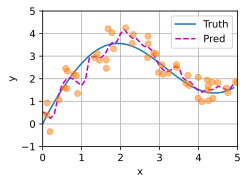

In [28]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

### 曲线在注意力权重较大的区域变得更不平滑

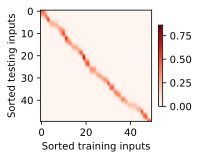

In [29]:
# only give relatively large weights to x_i's that are nearby
d2l.show_heatmaps(
    net.attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

## Attention Scores

* 假设query $\mathbf{q} \in \mathbb{R}^q$, $m$对key-value$(k_1, v_1)$, 这里$k_i \in \mathbb{R}^k, v_i \in \mathbb{R}^v$


* 注意力池化层：
$$
f(q, (k_1, v_1), ..., (k_m,v_m)) = \sum^{m}_{i=1} \alpha(\mathbf{q},\mathbf{k}_i)\mathbf{v}_i \in \mathbb{R}^v
$$

and we define attention score $a(\mathbf{q},\mathbf{k}_i)$, then we have

$$
\alpha(\mathbf{q},\mathbf{k}_i)  = \mathrm{softmax}(a(\mathbf{q},\mathbf{k}_i)) = \frac{\exp(a(\mathbf{q},\mathbf{k}_i))}{\sum^m_{j=1}\exp(a(\mathbf{q},\mathbf{k}_i))} \in \mathbb{R}
$$

### Additive Attention

* 可学参数：
$$
\mathbf{W}_k \in \mathbb{R}^{h\times k},  \mathbf{W}_q \in \mathbb{R}^{h\times q}, \mathbf{v} \in \mathbb{R}^h
$$


$$
a(\mathbf{k}, \mathbf{q}) = \mathbf{v}^T \tanh (\mathbf{W}_k\mathbf{k} + \mathbf{W}_q\mathbf{q})
$$


* 等价于将key和value合并起来放入一个隐藏大小为$h$输出大小为1的单隐藏层MLP

In [13]:
from utils import sequence_mask, masked_softmax

In [14]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.3567, 0.6433, 0.0000, 0.0000],
         [0.3288, 0.6712, 0.0000, 0.0000]],

        [[0.4212, 0.3051, 0.2737, 0.0000],
         [0.2857, 0.4111, 0.3032, 0.0000]]])

In [15]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4187, 0.3370, 0.2444, 0.0000]],

        [[0.5326, 0.4674, 0.0000, 0.0000],
         [0.2901, 0.2145, 0.2622, 0.2332]]])

In [16]:
class AdditiveAttention(nn.Module):
    
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [17]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10,
                                                       4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

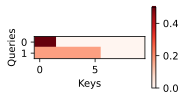

In [18]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

### Scaled Dot-Product Attention

* 如果query和key都是同样长度，$\mathbf{q}, \mathbf{k}_i \in \mathbb{R}^d$,那么可以：
$$
a(\mathbf{q}, \mathbf{k}_i) = <\mathbf{q}, \mathbf{k}_i>/\sqrt{d}
$$


* 向量化版本
    * $Q \in \mathbb{R}^{n\times d}, K \in \mathbb{R}^{m\times d}, V \in \mathbb{R}^{m\times v}$
    
    * 注意力分数： $a(\mathbf{Q}, \mathbf{K}) = \mathbf{QK}^T / \sqrt{d} \in \mathbb{R}^{n\times m}$
    
    * 注意力池化：$f = \mathrm{softmax}(a(\mathbf{Q}, \mathbf{K}))\mathbf{V} \in \mathbb{R}^{m \times n}$

In [23]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [24]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

# Self-attention

* 给定序列$\mathbf{x}_1, ..., \mathbf{x}_n, \forall\mathbf{x}_i \in \mathbb{R}^{d}$


* 自注意力池化层将$\mathbf{x}_i$当作key, value, query来对序列抽取特征得到$\mathbf{y}_1, ..., \mathbf{y}_n$, 这里


$$
\mathbf{y}_i = f(\mathbf{x}_i, (\mathbf{x}_1, \mathbf{x}_1), ..., (\mathbf{x}_n, \mathbf{x}_n)) \in \mathbb{R}^d
$$


* Key, query, value都来自于自己，区别于seq2seq_attention中key, value来自encoder而query来自decoder





## 和CNN,RNN对比

<img src="./cnn_rnn_selfattn.PNG" width="900">
<img src="./cnn_rnn_selfattn_comparison.PNG" width="500">


* seq很长时候自注意力复杂度较高， 但是CNN & RNN当维度大的时候复杂度高


* 但是自注意力的并行度很好， 尤其是TPU，大矩阵乘法


* 自注意力最长路径O(1)，就算出现在很远的地方，也能很简单的抓取过来。（但是很贵）

## Positional Encoding

* 和CNN/RNN不同，自注意力并没有记录位置信息


* 位置编码将位置信息注入到输入里


    * 假设长度为n的序列是$\mathbf{X}\in\mathbb{R}^{n\times d}$, 那么使用位置编码矩阵$\mathbf{P} \in \mathbb{R}^{n\times d}$来输出$\mathbf{X} + \mathbf{P}$作为自编码输入 
    * pros: 不改变模型，不改变数据大小; cons:模型能不能认出
    
    
* $\mathbf{P}$的元素如下计算：


$$
p_{i,2j} = \sin\left(\frac{i}{10000^{2j/d}}\right), \;p_{i,2j+1} = \cos\left(\frac{i}{10000^{2j/d}}\right)
$$


           

## Relative Positional Information
* 位置于$i+\delta$处的位置编码可以线性投影位置$i$处的位置编码来表示


* 记$\omega_j = 1/10000^{2j/d}$, 那么


$$
\begin{bmatrix}
   \cos(\delta\omega_j) & \sin(\delta\omega_j) \\
   -\sin(\delta\omega_j) & \cos(\delta\omega_j)
\end{bmatrix}
\begin{bmatrix}
   p_{i,2j} \\
   p_{i,2j+1}
\end{bmatrix}
=
\begin{bmatrix}
   p_{i+\delta,2j} \\
   p_{i+\delta,2j+1}
\end{bmatrix}
$$

* 投影矩阵跟$i$无关

## 代码实现

In [31]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                   num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [32]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

In [35]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
                         -1, 1) / torch.pow(
                             10000,
                             torch.arange(0, num_hiddens, 2, dtype=torch.float32) /
                             num_hiddens)
        self.P[:, :, ::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
        
    def forward(self, X):
        X += self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

### 行代表标记在序列中的位置，列代表位置编码的不同维度

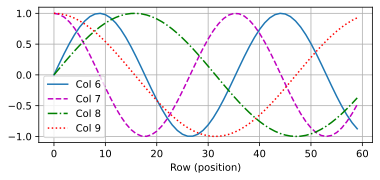

In [36]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

### 在编码维度上降低频率

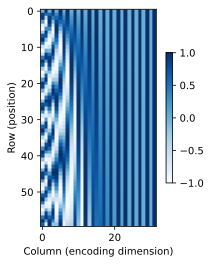

In [37]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')